## Importing Necessary Libraries

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torch.optim as optim
import torchvision.models as models
from torchvision import transforms
import warnings
warnings.filterwarnings('ignore')

**Selecting device to train model on**

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

## 1. Building a Custom Dataset from the IDD Segmentation dataset
 - Takes input as image and json directory path, then accessing the ith element returns a tuple of (image,mask) in which the mask is generated using the json folder

In [3]:
class IDDRoadDataset(Dataset):
    def __init__(self, image_dir, json_dir, transform=None):
        self.image_dir = image_dir
        self.json_dir = json_dir
        self.transform = transform
        self.image_files = self._get_files()

    def _get_files(self):
        # List all images in the image directory
        image_files = []
        for root, dirs, files in os.walk(self.image_dir):
            for file in files:
                if file.endswith('_leftImg8bit.png'):
                    image_files.append(os.path.join(root, file))
        return image_files

    def __len__(self):
        return len(self.image_files)

    def _get_json_path(self, image_path):
        json_filename = image_path.split('/')[-1].replace('_leftImg8bit.png', '_gtFine_polygons.json')
        json_path = image_path.replace('_leftImg8bit.png', '_gtFine_polygons.json').replace('leftImg8bit', 'gtFine')
        return json_path
    def _get_mask(self, json_path, image_shape):
        # Load JSON annotation file and create a mask for the "road" label
        with open(json_path) as f:
            data = json.load(f)
        
        # Create a blank mask (single channel) with the same dimensions as the image
        mask = np.zeros((image_shape[0], image_shape[1]), dtype=np.uint8)
        
        # Loop over the objects in the JSON file
        for obj in data['objects']:
            if 'polygon' in obj:
                polygon = np.array(obj['polygon'], np.int32)
                polygon = polygon.reshape((-1, 1, 2))  # Reshape for OpenCV

                if obj['label'] in ['road','parking']:
                    # Fill the road polygon with white (255)
                    cv2.fillPoly(mask, [polygon], 255)
                else:
                    # Fill other polygons with black (0)
                    cv2.fillPoly(mask, [polygon], 0)

        return mask

    def __getitem__(self, idx):
        image_path = self.image_files[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        json_path = self._get_json_path(image_path)
        mask = self._get_mask(json_path, image.shape[:2])

        # Convert to PIL Image for PyTorch transforms
        image = T.functional.to_pil_image(image)
        mask = T.functional.to_pil_image(mask)

        if self.transform:
            image = self.transform(image)  # Apply the image transform
            mask = self.transform(mask)  # Convert mask to tensor

        return image, mask


### Testing the Dataset

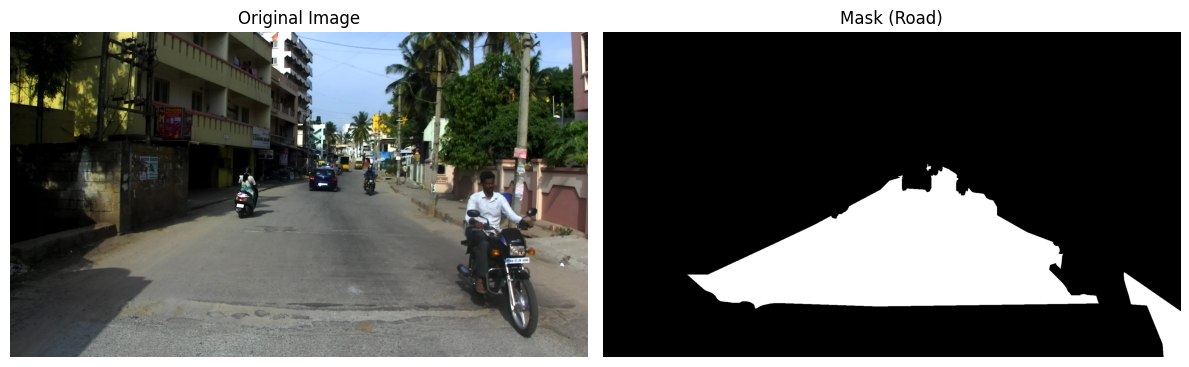

In [4]:
ds=IDDRoadDataset('IDD_Segmentation/leftImg8bit/train','IDD_Segmentation/gtFine/train')
img,msk=ds[40]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Display the original image
ax[0].imshow(img)
ax[0].set_title('Original Image')
ax[0].axis('off')  # Hide axis

# Display the actual mask
ax[1].imshow(msk, cmap='gray')
ax[1].set_title('Mask (Road)')
ax[1].axis('off')  # Hide axis
plt.tight_layout()
plt.show()

## 2. Building Custom U-Net with ResNet50 backbone

In [5]:
class UNetResNet50(nn.Module):
    def __init__(self, pretrained=True):
        super(UNetResNet50, self).__init__()
        
        # Load the pre-trained ResNet50 model from torchvision
        resnet = models.resnet50(pretrained=pretrained)
        
        # Extract layers from ResNet50
        self.encoder0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool).to(device)
        self.encoder1 = resnet.layer1
        self.encoder2 = resnet.layer2
        self.encoder3 = resnet.layer3
        self.encoder4 = resnet.layer4
        
        # Decoder (Upsampling)
        self.decoder4 = self.upconv_block(2048, 1024)
        self.decoder3 = self.upconv_block(1024, 512)
        self.decoder2 = self.upconv_block(512, 256)
        self.decoder1 = self.upconv_block(256, 64)
        self.decoder0 = self.upconv_block(64, 64)
        
        # Final conv layer
        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)
        # Upsample layers to match the skip connection sizes
        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(out_channels, out_channels, kernel_size=2, stride=2)
        ).to(device)
    
    def forward(self, x):
        # Encoder
        e0 = self.encoder0(x)   # Output size: 64x128x128
        e1 = self.encoder1(e0)  # Output size: 256x128x128
        e2 = self.encoder2(e1)  # Output size: 512x64x64
        e3 = self.encoder3(e2)  # Output size: 1024x32x32
        e4 = self.encoder4(e3)  # Output size: 2048x16x16
        
        # Decoder with skip connections
        d4 = self.decoder4(e4) + e3  # Output size: 1024x32x32
        d3 = self.decoder3(d4) + e2  # Output size: 512x64x64
        d2 = self.decoder2(d3) + e1  # Output size: 256x128x128
        d1 = self.decoder1(d2) + self.upsample1(e0)  # Output size: 64x128x128
        d0 = self.decoder0(d1)       # Output size: 64x256x256
        
        out = self.final_conv(d0)    # Output size: 1x256x256
        return out.to(device)

# Instantiate model
model = UNetResNet50(pretrained=True).to(device)

# Define loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


## 3. Defining Metrics for the Model
 * We will be using Intersection over Union (IoU) and DICE scores to see how similar the geenrated mask is with respect to  the actual mask

In [6]:
def iou_metric(y_true, y_pred):
    y_pred = (y_pred > 0.5).astype(np.uint8)
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return intersection / union

def dice_metric(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = (y_pred.flatten() > 0.5).astype(np.uint8)
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred))

## 4. Train function for the U-Net
 - Tracks every epoch, and has early stopping with patience
 - saves the best model
 - stores loss, mean IoU and DICE score after each epoch to show graphically later on (Though tensorboard is a better option than this, as it provides live monitoring)
 - used `tqdm` to show progress of for loop (number of batches have been processed in the current epoch)

In [7]:
def train(model, train_loader, val_loader, epochs=25, patience=5):
    train_losses = []
    val_losses = []
    iou_scores = []
    dice_scores = []
    best_val_loss = float('inf')
    early_stop_counter = 0

    for epoch in range(epochs):
        epoch_loss = 0
        val_loss = 0
        iou_score = 0
        dice_score = 0
        
        # Training phase
        model.train()
        with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
            for images, masks in train_loader:
                images = images.to(device)
                masks = masks.to(device)
                model = model.to(device)
                
                optimizer.zero_grad()
                outputs = model(images)
                loss = loss_fn(outputs, masks.float())
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()
                pbar.set_postfix(loss=loss.item())
                pbar.update(1)

        # Validation phase
        model.eval()
        with tqdm(total=len(val_loader), desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
            with torch.no_grad():
                for val_images, val_masks in val_loader:
                    val_images = val_images.to(device)
                    val_masks = val_masks.to(device)
                    model = model.to(device)
                    
                    val_outputs = model(val_images)
                    val_loss += loss_fn(val_outputs, val_masks.float()).item()
                    
                    val_outputs_np = val_outputs.detach().cpu().numpy()
                    val_masks_np = val_masks.cpu().numpy()
                    
                    iou_score += iou_metric(val_masks_np, val_outputs_np)
                    dice_score += dice_metric(val_masks_np, val_outputs_np)
                    pbar.update(1)

        avg_train_loss = epoch_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        avg_iou = iou_score / len(val_loader)
        avg_dice = dice_score / len(val_loader)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        iou_scores.append(avg_iou)
        dice_scores.append(avg_dice)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, IoU: {avg_iou:.4f}, Dice: {avg_dice:.4f}")

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            early_stop_counter = 0  # Reset counter when validation loss improves
            torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    return train_losses, val_losses, iou_scores, dice_scores


## 5. Function to plot metrics, which are obtained from the training loop

In [8]:
def plot_metrics(train_losses, val_losses, iou_scores, dice_scores):
    epochs = len(train_losses)
    
    plt.figure(figsize=(12, 8))
    
    # Plot Loss
    plt.subplot(2, 1, 1)
    plt.plot(range(epochs), train_losses, label='Train Loss')
    plt.plot(range(epochs), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss')
    plt.legend()

    # Plot IoU and Dice
    plt.subplot(2, 1, 2)
    plt.plot(range(epochs), iou_scores, label='IoU Score')
    plt.plot(range(epochs), dice_scores, label='Dice Score')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.title('IoU and Dice Scores')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [9]:
def get_dataloader(image_dir, json_dir, batch_size=4, shuffle=True, transform=None):
    dataset = IDDRoadDataset(image_dir, json_dir, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

## Training Section
 - made dataloader for training and validation
 - called the training function to train over 10 epochs with early stopping patience 3
 - Displayed loss , IoU and DICE over each epoch

In [ ]:
if __name__ == '__main__':
    # transforms an image to 256*256 in Dataset
    transform=T.Compose([
        T.Resize((256, 256)),            # Resize to 256 x 256
        T.ToTensor(),                    # Convert to Tensor
    ])
    train_image_dir = 'IDD_Segmentation/leftImg8bit/train'
    train_json_dir = 'IDD_Segmentation/gtFine/train'
    val_image_dir = 'IDD_Segmentation/leftImg8bit/val'
    val_json_dir = 'IDD_Segmentation/gtFine/val'
    
    train_loader = get_dataloader(train_image_dir, train_json_dir, batch_size=8,transform=transform)
    # print(train_loader.num_workers)
    val_loader = get_dataloader(val_image_dir, val_json_dir, batch_size=8,transform=transform)

    train_losses, val_losses, iou_scores, dice_scores = train(model, train_loader, val_loader, epochs=3)

    # Plot the metrics after training
    plot_metrics(train_losses, val_losses, iou_scores, dice_scores)


## Experimenting(Testing the trained model)

In [11]:
def load_actual_mask(image_path, json_path):
    """
    Load the actual mask from the JSON annotation file based on the image path.
    
    Args:
    - image_path (str): Path to the image.
    - json_path (str): Path to the JSON file.
    
    Returns:
    - np.ndarray: The mask image where road pixels are set to 255 and others remain 0.
    """
    # Load the image to get its shape
    image = cv2.imread(image_path)
    image_shape = image.shape[:2]  # Get height and width

    # Create a blank mask (all black)
    mask = np.zeros(image_shape, dtype=np.uint8)

    # Load the JSON annotation file
    with open(json_path) as f:
        data = json.load(f)

    # Loop over the objects in the JSON
    for obj in data['objects']:
        label = obj['label']
        
        # Check if the label is "road"
        if 'polygon' in obj:
            polygon = np.array(obj['polygon'], np.int32)
            polygon = polygon.reshape((-1, 1, 2))  # Reshape for OpenCV
            if label in ['road','parking']:
                # Fill the road polygon with white (255) in the binary mask
                cv2.fillPoly(mask, [polygon], 255)
            else:
                cv2.fillPoly(mask, [polygon], 0)             

    return mask

# Example usage
image_path = "/Users/rasesh/Developer/Inter IIT/CV/IDD_Segmentation/leftImg8bit/train/0/005506_leftImg8bit.png"
json_path = "/Users/rasesh/Developer/Inter IIT/CV/IDD_Segmentation/gtFine/train/0/005506_gtFine_polygons.json"

# Load the actual mask
actual_mask = load_actual_mask(image_path, json_path)


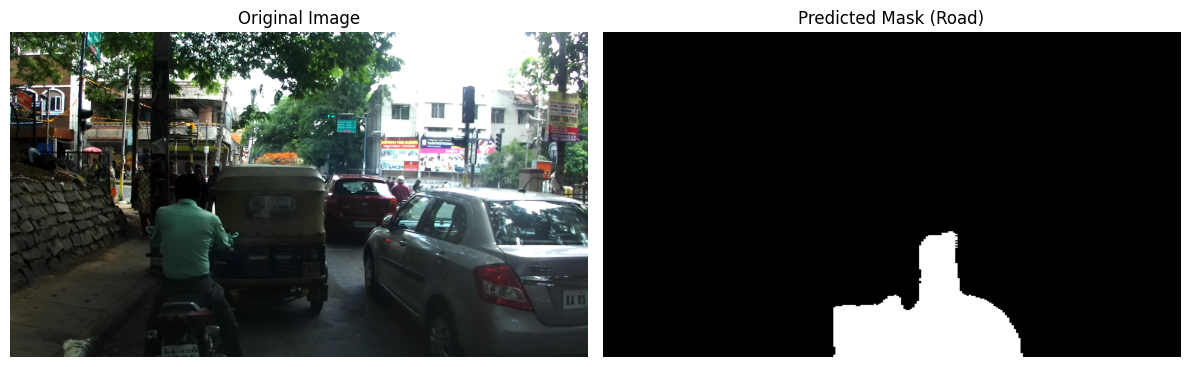

In [12]:
def get_predicted_mask(model, image_path, device):
    """
    Get the predicted mask from the model for a given image.

    Args:
    - model (torch.nn.Module): The trained model.
    - image_path (str): Path to the image.
    - device (torch.device): Device to run the model on (e.g., 'cuda', 'cpu', or 'mps').

    Returns:
    - np.array: Predicted binary mask as a NumPy array.
    """
    
    # Load and preprocess the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    original_size = image.shape[:2]  # Store original size for resizing the mask back

    # Resize the image to match model input size (assuming 256x256)
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])

    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Set model to evaluation mode and get the predicted mask
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)

    # Convert the predicted mask to binary format (threshold at 0.5)
    predicted_mask = output.squeeze(0).cpu().numpy()  # Remove batch dimension
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)  # Threshold the output

    # Resize the mask back to the original image size
    predicted_mask_resized = cv2.resize(predicted_mask[0], (original_size[1], original_size[0]))

    return predicted_mask_resized
# Example usage
# Assume `model` is already loaded and trained, and `device` is set.

image_path = "IDD_Segmentation/leftImg8bit/test/120/109283_leftImg8bit.png" # a test image with heacy traffic
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Display the original image
ax[0].imshow(image)
ax[0].set_title('Original Image')
ax[0].axis('off')  # Hide axis

predicted_mask = get_predicted_mask(model, image_path, device)
# Display the actual mask
ax[1].imshow(predicted_mask, cmap='gray')
ax[1].set_title('Predicted Mask (Road)')
ax[1].axis('off')  # Hide axis
plt.tight_layout()
plt.show()


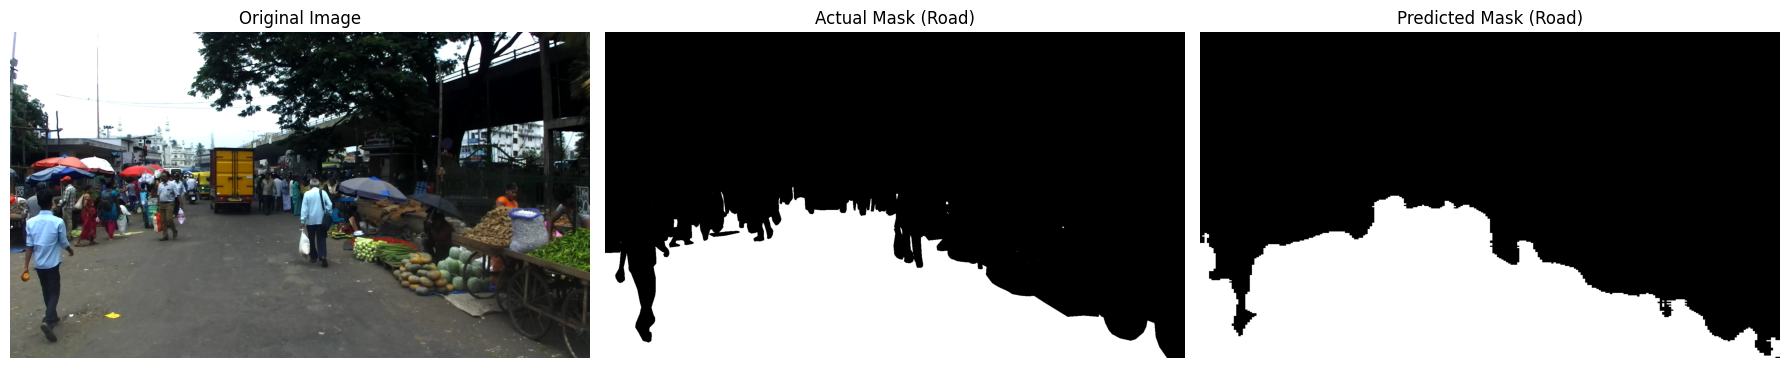

IoU Score for the image: 0.9324517123897013


In [13]:
def display_image_and_masks(image_path, actual_mask, predicted_mask):
    # Load and process the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    # Create a figure with three subplots
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    # Display the original image
    ax[0].imshow(image)
    ax[0].set_title('Original Image')
    ax[0].axis('off')  # Hide axis

    # Display the actual mask
    ax[1].imshow(actual_mask, cmap='gray')
    ax[1].set_title('Actual Mask (Road)')
    ax[1].axis('off')  # Hide axis

    # Display the predicted mask
    ax[2].imshow(predicted_mask, cmap='gray')
    ax[2].set_title('Predicted Mask (Road)')
    ax[2].axis('off')  # Hide axis

    plt.tight_layout()
    plt.show()

# Assuming you have the actual mask and predicted mask ready
# predicted_mask = val_outputs_np[0]  # Example for the first image in batch
image_path = "IDD_Segmentation/leftImg8bit/train/118/086233_leftImg8bit.png"
json_path = "IDD_Segmentation/gtFine/train/118/086233_gtFine_polygons.json"
actual_mask = load_actual_mask(image_path,json_path)  # Replace this with your actual mask loading logic
predicted_mask = get_predicted_mask(model, image_path, device)

display_image_and_masks(image_path, actual_mask, predicted_mask)
print("IoU Score for the image:",iou_metric(predicted_mask,actual_mask))

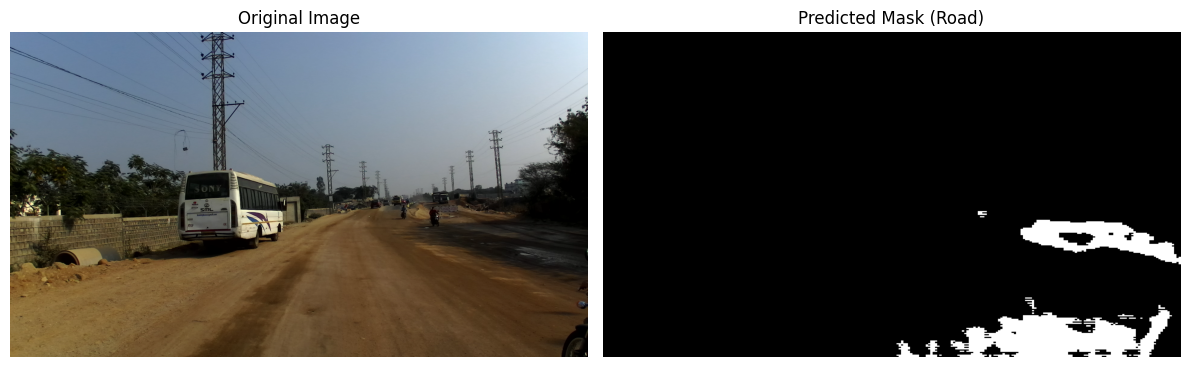

In [14]:
image_path = "IDD_Segmentation/leftImg8bit/test/161/001577_leftImg8bit.png" #random image picked from internet
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Display the original image
ax[0].imshow(image)
ax[0].set_title('Original Image')
ax[0].axis('off')  # Hide axis

predicted_mask = get_predicted_mask(model, image_path, device)
# Display the actual mask
ax[1].imshow(predicted_mask, cmap='gray')
ax[1].set_title('Predicted Mask (Road)')
ax[1].axis('off')  # Hide axis
plt.tight_layout()
plt.show()

In [ ]:
torch.save(model.state_dict(),"best_model.pth")

In [18]:
model = UNetResNet50(pretrained=True).to(device)
model.load_state_dict(torch.load("best_model2.pth", weights_only=True))

<All keys matched successfully>

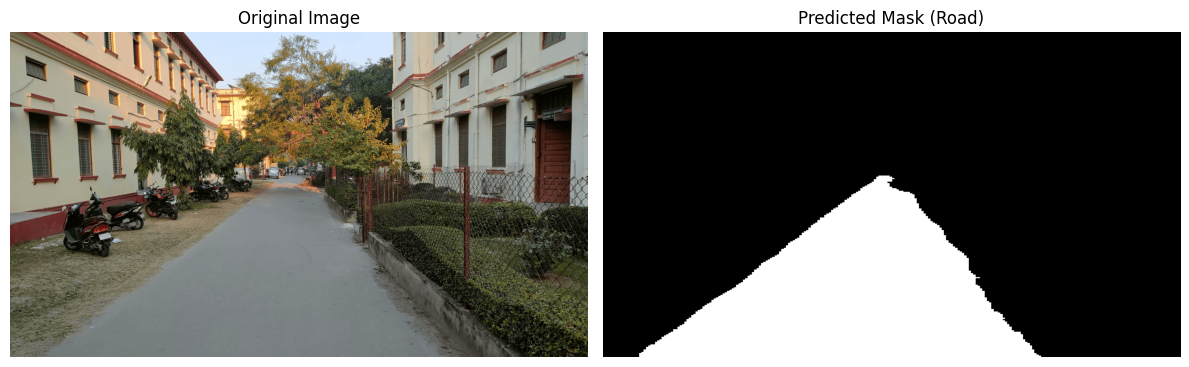

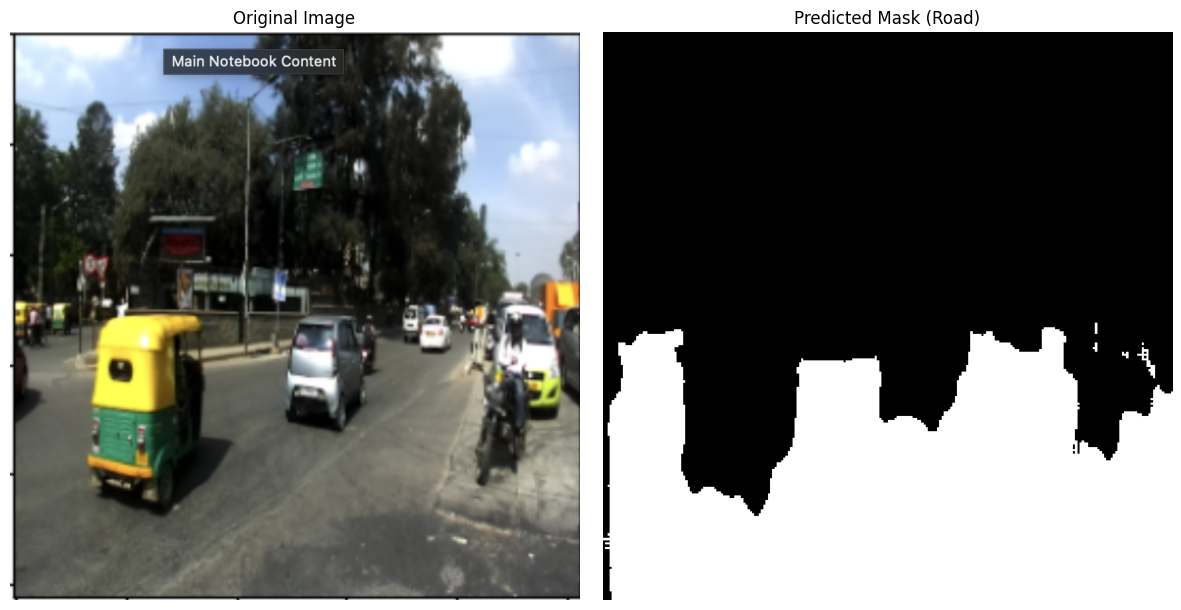

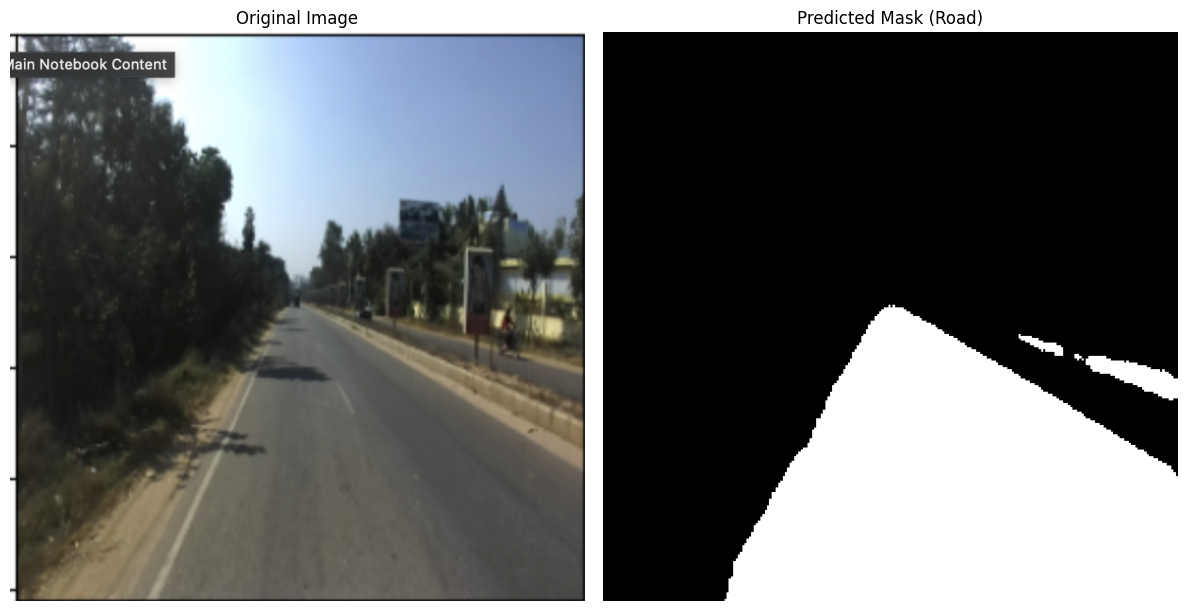

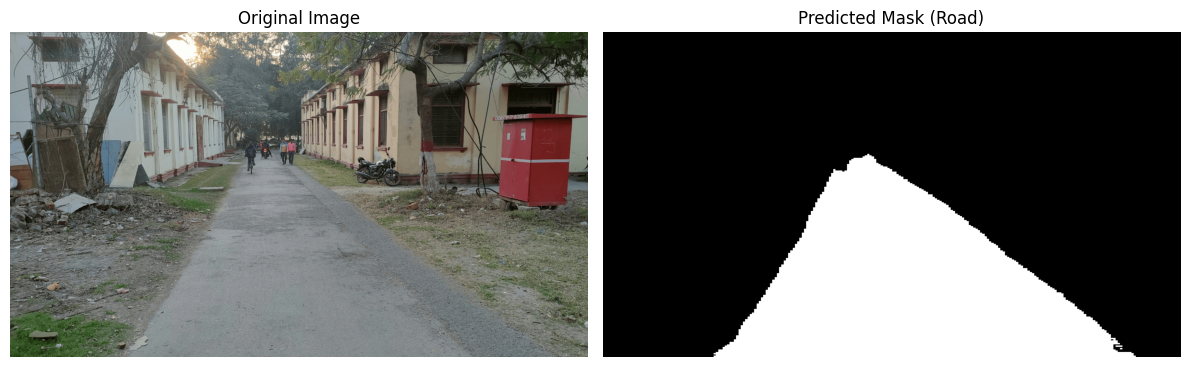

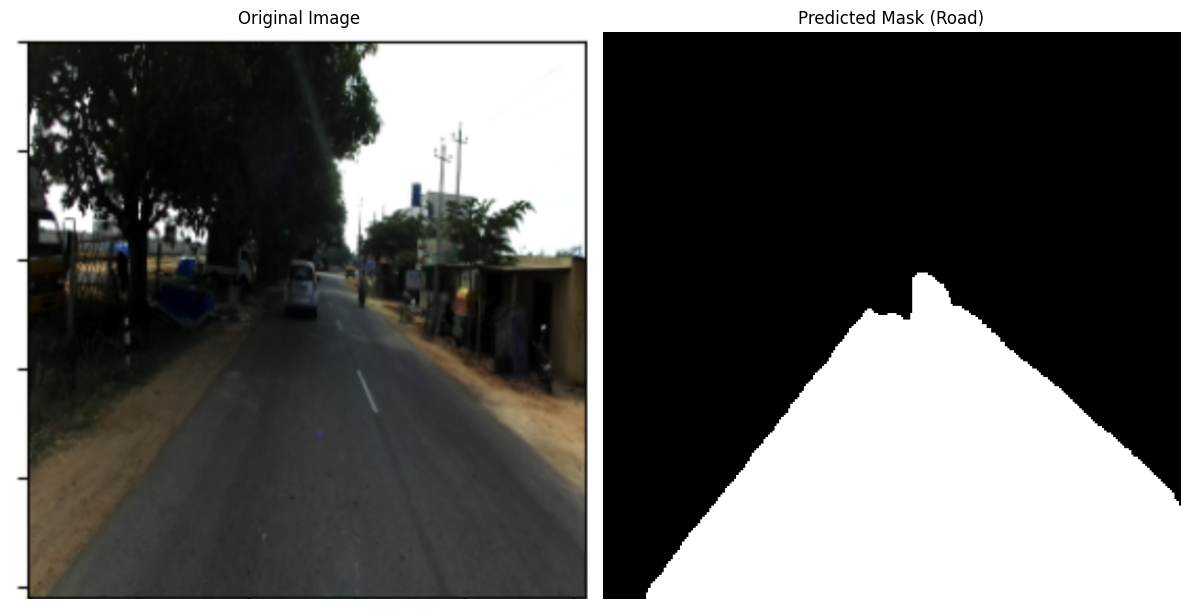

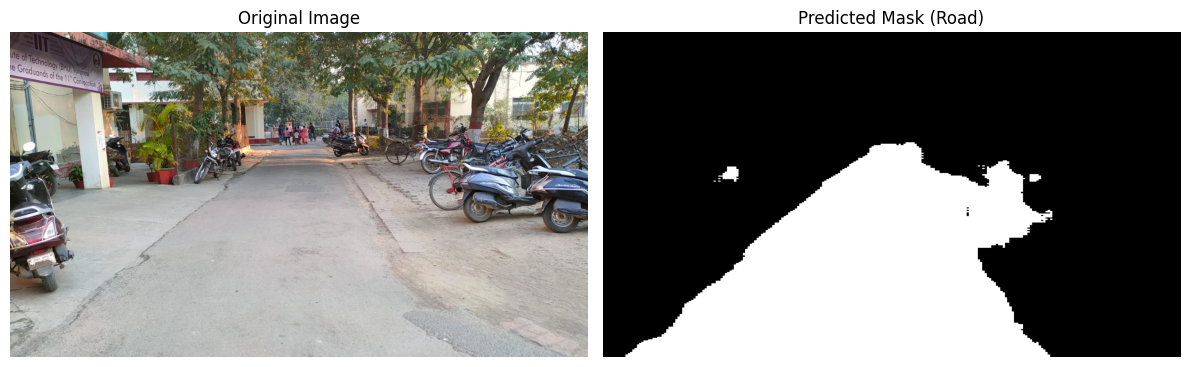

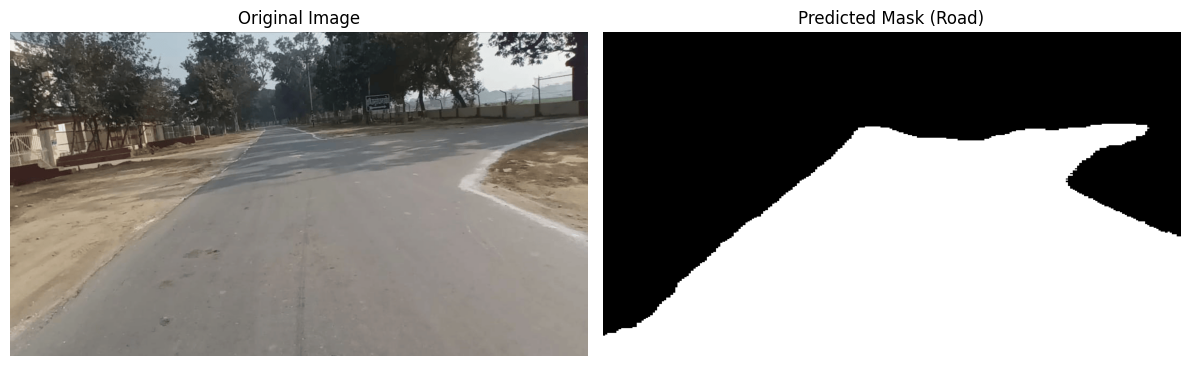

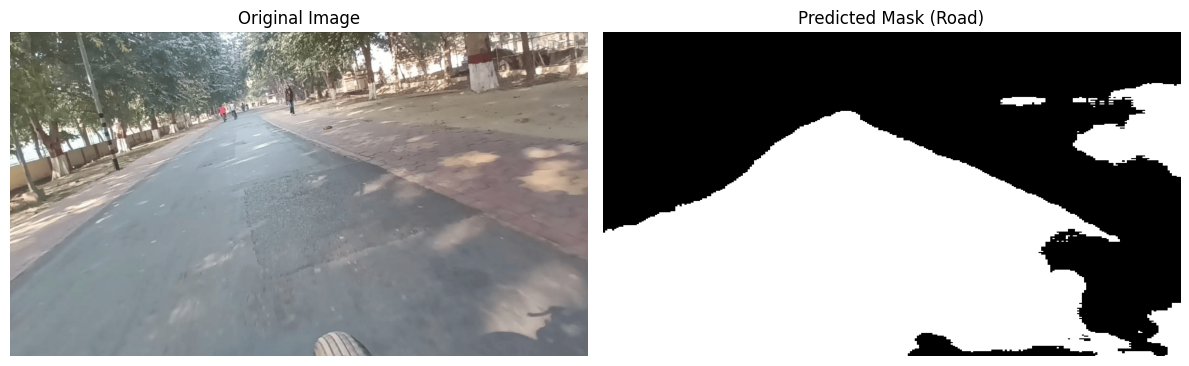

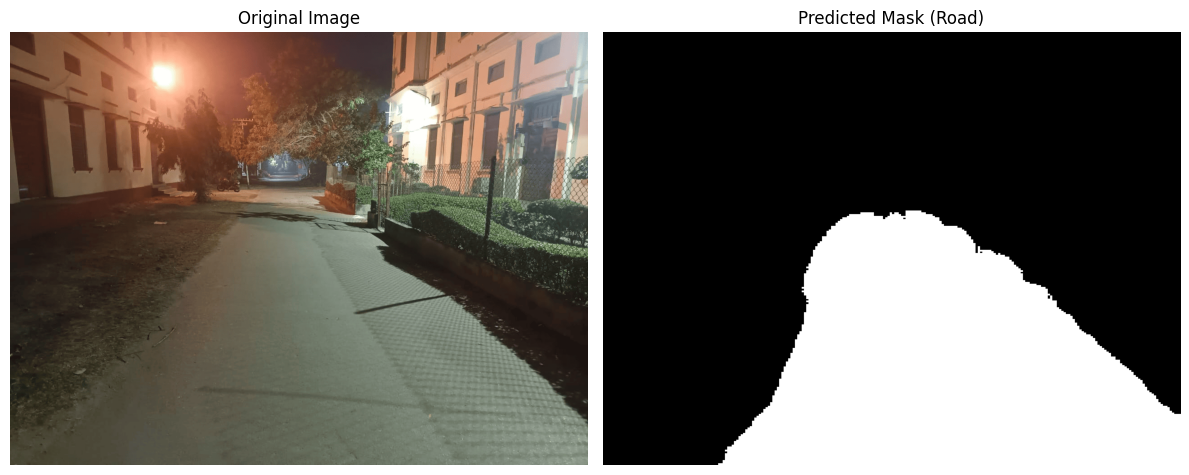

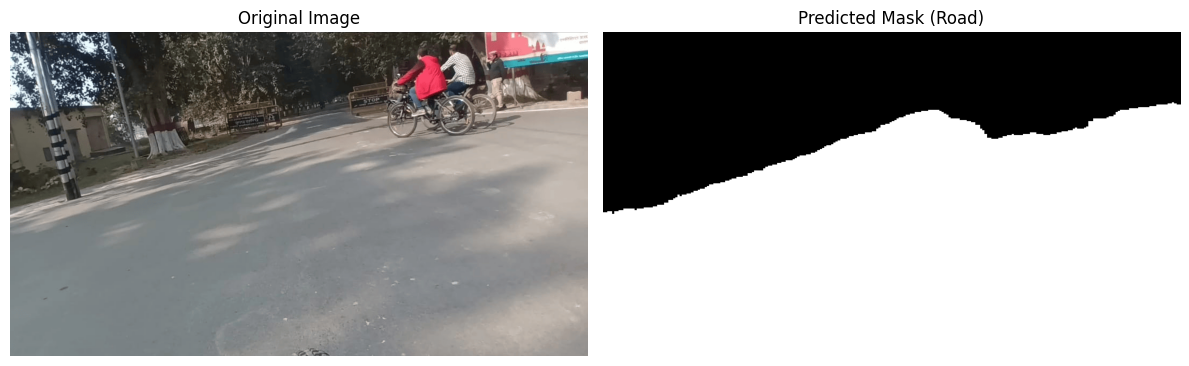

In [19]:
for file_name in os.listdir('sample images'):
    if file_name.endswith('.png'):
        image_path=f'sample images/{file_name}'
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        
        # Display the original image
        ax[0].imshow(image)
        ax[0].set_title('Original Image')
        ax[0].axis('off')  # Hide axis
        
        predicted_mask = get_predicted_mask(model, image_path, device)
        # Display the actual mask
        ax[1].imshow(predicted_mask, cmap='gray')
        ax[1].set_title('Predicted Mask (Road)')
        ax[1].axis('off')  # Hide axis
        plt.tight_layout()
        plt.show()

# Trying to make this model work on live road segmentation task in a video

In [24]:
import cv2
import torch
import numpy as np
from torchvision import transforms
from tqdm import tqdm

# Define preprocessing for video frames
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),  # Resize to match the input size of the model
])

def postprocess(mask):
    """
    Postprocess the model output to convert it to a binary mask.
    """
    mask = torch.sigmoid(mask)  # Apply sigmoid to get probabilities
    mask = (mask > 0.54).cpu().numpy().astype(np.uint8)  # Threshold the mask
    mask = np.squeeze(mask)  # Remove unnecessary dimensions
    return mask

# Load the trained model
# model = UNetResNet50(pretrained=False)
# model.load_state_dict(torch.load('best_model.pth'))
model = model.to(device)
model.eval()

# Open the video file using OpenCV
video_path = 'video2.mp4'  # Specify the path to your MP4 video
cap = cv2.VideoCapture(video_path)

# Get video information (e.g., width, height, frame rate)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Video writer to save output
out = cv2.VideoWriter('output_video.avi', cv2.VideoWriter_fourcc(*'XVID'), fps, (frame_width, frame_height))

skip_frames = 3 # Only predict on every 3rd frame
frame_count = 0
# Example of tracing the model for optimization
# traced_model = torch.jit.trace(model, torch.randn(1, 3, 256, 256).to(device))
# Process each frame in the video
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1
    if frame_count % skip_frames != 0:
        continue  # Skip this frame if not processing

    # Preprocess the frame
    input_frame = preprocess(frame).unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Predict the mask
    with torch.no_grad():
        predicted_mask = model(input_frame)

    # Postprocess the mask to convert it to a binary mask
    mask = postprocess(predicted_mask)

    # Resize mask to original frame size
    mask_resized = cv2.resize(mask, (frame_width, frame_height))

    # Create a color mask to overlay on the original frame
    color_mask = np.zeros_like(frame)
    color_mask[:, :, 1] = mask_resized * 255  # Apply mask in the green channel

    # Overlay mask on original frame
    overlayed_frame = cv2.addWeighted(frame, 0.7, color_mask, 0.3, 0)

    # Display the frame with mask
    cv2.imshow('Road Segmentation', overlayed_frame)

    # Write the frame with overlayed mask to the output video
    out.write(overlayed_frame)
    # Press 'q' to quit early
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture and writer
cap.release()
out.release()
cv2.destroyAllWindows()